In [1]:
import pickle

# open a file, where you ant to store the data
with open('./processed.pickle', 'rb') as processed_file:

    # dump information to that file
    requests = pickle.load(processed_file)

## Analyze tags

In [2]:
from torch.nn import functional as F

def get_dist(type, idx, upper=50, lower=-2, output_probs=False):
    if output_probs:
        values = F.softmax(requests[type][idx][2], dim=-1)
    else:
        values = requests[type][idx][2]
        
    values = values.tolist()
    
    return [min(upper, max(lower, v)) for v in values]

## Visualize

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from mplcursors import cursor

# Plotting
def plot(type, idx, output_probs=False):
    dist = get_dist(type, idx, output_probs=output_probs)

    plt.clf()
    plt.figure(figsize=(15, 6))
    plt.plot(dist, marker='o', linestyle='-', color='blue')
    plt.title(f'Plot of result {idx}')
    plt.xlabel('Index')
    plt.ylabel('Logit')
    
    # Highlighting tags
    # b : blue · g : green · r : red · c : cyan · m : magenta · y : yellow · k : black
    colors = "b,g,r,c,m,y,k".split(',')
    
    for (tag, id), color in zip(tag_id_map.items(), colors):
        plt.axvline(x=id, color=color, linestyle='--', label=tag)  # Indices are 0-based

    # Dotted horizontal line on zero
    plt.axhline(y=0, color='y', linestyle=':', label='y=0 Line')

    plt.legend()
    cursor(hover=True)

    plt.show()



In [4]:
%matplotlib widget
show = lambda type, idx, output_probs=False: (requests[type][idx][0], plot(type, idx, output_probs))

In [5]:
from transformers import AutoTokenizer

model_name = "julep-ai/samantha-1-turbo"
tokenizer = AutoTokenizer.from_pretrained(model_name)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
# List of tags 
allowed_tags = ["me", "function_call", "thought"]
disallowed_tags = ["situation", "person", "functions", "information"]
tags = allowed_tags + disallowed_tags

allowed_tag_token_ids = [
    tokenizer(tag, add_special_tokens=False)["input_ids"]
    for tag in allowed_tags
]

disallowed_tag_token_ids = [
    tokenizer(tag, add_special_tokens=False)["input_ids"]
    for tag in disallowed_tags
]

tag_token_ids = [
    tokenizer(tag, add_special_tokens=False)["input_ids"]
    for tag in tags
]

tag_id_map = {
    tag: tag_ids[0]
    for tag, tag_ids in zip(tags, tag_token_ids)
}

id_tag_map = {
    id: tag
    for tag, id in tag_id_map.items()
}

In [7]:
get_points = lambda type, select_tags, limit=-1: [
    req[2].tolist()
    if select_tags is None
    else [
        req[2][tag_id_map[tag]].item()
        for tag in select_tags
    ]
    for req in requests[type][:limit]
]

In [8]:
positive_points = get_points("positive", ["me", "function_call"])
negative_points = get_points("negative", ["me", "function_call"])

positive_xs, positive_ys = zip(*positive_points)
negative_xs, negative_ys = zip(*negative_points)

xs = positive_xs + negative_xs
ys = positive_ys + negative_ys
colors = ['b']*len(positive_xs) + ['r']*len(negative_xs)

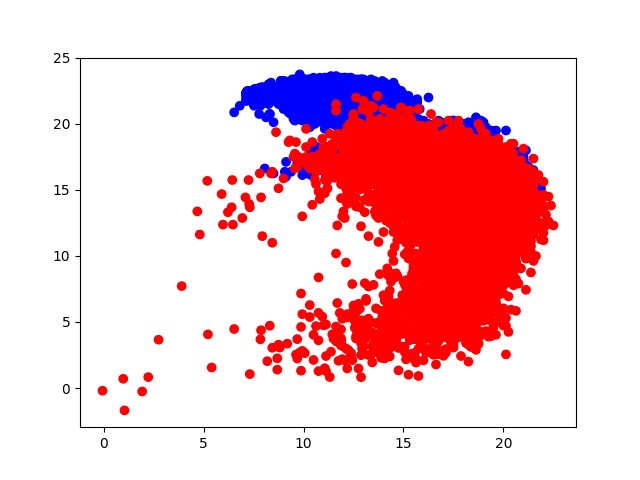

In [9]:
plt.clf()
plt.scatter(xs, ys, c=colors)
plt.show()

In [10]:
import torch
torch.tensor(range(10))[[1,2]]

tensor([1, 2])

In [11]:
# Get data points and labels
def get_training_points(select_tags, limit=-1):
    data = []
    labels = []

    for label, type in enumerate(["negative", "positive"]):
        samples = requests[type][:limit]

        for sample in samples:
            logit_tensor = sample[2]
            
            if select_tags:
                logit_tensor = logit_tensor[[
                    tag_id_map[tag]
                    for tag in select_tags
                ]]

            data.append(logit_tensor.to(torch.float16))
            labels.append(label)

    return data, labels

In [12]:
data, labels = get_training_points(tags) #["me", "function_call"])

In [22]:
from sklearn.model_selection import train_test_split

# Assuming 'data' is your features and 'labels' are the true labels
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.7, random_state=42)

In [23]:
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
import torch

def train_gradient_boosted_trees(data, labels):
    # Convert the list of tensors to a numpy array
    X = np.vstack([tensor.numpy() for tensor in data])

    # Convert the list of labels to a numpy array
    y = np.array(labels)

    # Initialize the gradient-boosted trees model
    model = GradientBoostingClassifier()

    # Train the model
    model.fit(X, y)

    return model

In [24]:
model = train_gradient_boosted_trees(X_train, y_train)

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)[:, 1]  # Assuming the positive class is at index 1

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, probabilities)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC-AUC Score: {roc_auc}")

Accuracy: 0.9899947676718692
Precision: 0.9905596516584643
Recall: 0.9950745253717079
F1 Score: 0.992811955624828
ROC-AUC Score: 0.999053095003397


In [34]:
model.predict(np.array(range(7)).reshape(1, -1))
# model.predict

array([0])

In [31]:
with open("model.np", "wb") as f:
    pickle.dump(model, f)